<a href="https://colab.research.google.com/github/Bertal-Youssef/BashTaskMaster/blob/main/pest_disease_detection_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing needed files

In [2]:
from google.colab import files
uploaded = files.upload()


Saving pest_disease_detection_cnn.ipynb to pest_disease_detection_cnn.ipynb


In [ ]:
import os
import sys
import time
import torch
import shutil
import random
import zipfile
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision.transforms as T

svn checkout https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/{folder_of_interest}

### Renaming the files of interest

In [ ]:
import zipfile, os

with zipfile.ZipFile("archive_data.zip", "r") as zip_ref:
    zip_ref.extractall("data")   # extract into a folder called 'data'




In [ ]:
train_dir = "data/idata/Image Dataset/ImageDataset/train"
valid_dir = "data/idata/Image Dataset/ImageDataset/valid"
test_dir  = "data/idata/Image Dataset/test_data/test"

print("Train classes:", os.listdir(train_dir))
print("Valid classes:", os.listdir(valid_dir))
print("Test classes :", os.listdir(test_dir))



Train classes: ['tomato_late', 'potato_early', 'potato_late', 'tomato_healthy', 'potato_healthy', 'tomato_early']
Valid classes: ['tomato_late', 'potato_early', 'potato_late', 'tomato_healthy', 'potato_healthy', 'tomato_early']
Test classes : ['potato_late_143.JPG', 'potato_early_118.JPG', 'tomato_early_7.JPG', 'tomato_late_225.JPG', 'tomato_early_151.JPG', 'tomato_late_157.JPG', 'tomato_late_364.JPG', 'potato_late_269.JPG', 'tomato_late_219.JPG', 'tomato_early_111.JPG', 'potato_early_240.JPG', 'tomato_late_826.JPG', 'potato_late_253.JPG', 'tomato_late_249.JPG', 'potato_late_377.JPG', 'tomato_late_783.JPG', 'tomato_healthy_109.JPG', 'tomato_early_413.JPG', 'potato_late_89.JPG', 'tomato_late_40.JPG', 'potato_early_116.JPG', 'potato_early_114.JPG', 'tomato_early_101.JPG', 'tomato_healthy_171.JPG', 'tomato_late_109.JPG', 'tomato_early_241.JPG', 'tomato_early_379.JPG', 'tomato_healthy_303.JPG', 'tomato_early_287.JPG', 'tomato_late_730.JPG', 'potato_late_221.JPG', 'potato_late_311.JPG', 'po

for fol in range(len(folders)):
    print(folderpath+folders[fol])
    for i in range(len(os.listdir(folderpath+folders[fol]))):
        if os.listdir(folderpath+folders[fol])[i].endswith('.svn'):
            print('Another svn file which will be ignored')
        else:
            fp = folderpath+folders[fol]
            os.rename(os.path.join(fp, os.listdir(folderpath+folders[fol])[i]), f'{fp}/{folders[fol]}_{i}.JPG')

nums = []
for file in os.listdir('../Dissertation/idata/Image Dataset/data_to_use/potato_healthy'):
    if len(file.split('.')[0].split('_')) ==3:
        number = file.split('.')[0].split('_')[-1]
        nums.append(int(number))
        
nums_used_for_renaming = []
for i in range(152):
    if i not in nums:
        nums_used_for_renaming.append(i)
len(nums_used_for_renaming)

path = '../Dissertation/idata/Image Dataset/data_to_use/potato_healthy'
for n in range(len(os.listdir(folderpath))):
    print(os.listdir(folderpath)[n])
    if len(os.listdir(folderpath)[n].split('.')[0].split('-')) >3: #can be either - or _
        os.rename(os.path.join(path, os.listdir(path)[n]), f"{path}/{path.split('/')[-1]}_{nums_used_for_renaming[n]}.JPG")

### Finding the number of files in each folder and total files overall

In [ ]:
import os

# Train
folderpath = "data/idata/Image Dataset/ImageDataset/train/"
folders = os.listdir(folderpath)

count = 0
for fol in folders:
    files = os.listdir(os.path.join(folderpath, fol))
    print(f"Number of files in {fol}: {len(files)}")
    count += len(files)

print(f"\nTotal train files: {count}")

# Valid
folderpath = "data/idata/Image Dataset/ImageDataset/valid/"
folders = os.listdir(folderpath)

count = 0
for fol in folders:
    files = os.listdir(os.path.join(folderpath, fol))
    print(f"Number of files in {fol}: {len(files)}")
    count += len(files)

print(f"\nTotal valid files: {count}")


Number of files in tomato_late: 2004
Number of files in potato_early: 1998
Number of files in potato_late: 1998
Number of files in tomato_healthy: 2003
Number of files in potato_healthy: 2008
Number of files in tomato_early: 1998

Total train files: 12009
Number of files in tomato_late: 225
Number of files in potato_early: 221
Number of files in potato_late: 221
Number of files in tomato_healthy: 222
Number of files in potato_healthy: 221
Number of files in tomato_early: 221

Total valid files: 1331


### Calculating the dataset splits

In [ ]:
print(f"Train: {round(0.6*count)}")
print(f"Valid: {round(0.2*count)}")
print(f"Test: {round(0.2*count)}")

Train: 799
Valid: 266
Test: 266


### Function to move files from one folder to another
I create this cell if we have less images in the validation set

In [ ]:
import os
import shutil
import random
from pathlib import Path

# Your current dataset paths
train_dir = Path("data/idata/Image Dataset/ImageDataset/train")
valid_dir = Path("data/idata/Image Dataset/ImageDataset/valid")
test_dir  = Path("data/idata/Image Dataset/test_data/test")  # flat files, no class subfolders

def move_files_randomly(src_dir: Path, dst_dir: Path, num: int,
                        exts=(".jpg", ".jpeg", ".png", ".bmp", ".JPG"), seed: int = 42):
    """
    Randomly move up to `num` image files from src_dir to dst_dir.

    - src_dir, dst_dir: Paths to class folders (e.g., train/potato_early -> valid/potato_early)
    - num: number of files to move (will cap to available)
    - exts: allowed image file extensions
    - seed: for reproducibility
    """
    assert src_dir.is_dir(), f"Source folder does not exist: {src_dir}"
    dst_dir.mkdir(parents=True, exist_ok=True)

    # Filter only image files
    files = [p for p in src_dir.iterdir() if p.is_file() and p.suffix in exts]
    if not files:
        print(f"No image files found in {src_dir}")
        return

    # Reproducible randomness
    random.seed(seed)
    random.shuffle(files)

    k = min(num, len(files))
    to_move = files[:k]

    for p in to_move:
        shutil.move(str(p), dst_dir / p.name)
    print(f"Finished moving {k} file(s) from {src_dir} -> {dst_dir}")

# EXAMPLE: move 40 images per class from train -> valid (keeps labels aligned)
# Only run this if you actually WANT to rebalance your split!
# for cls in os.listdir(train_dir):
#     src = train_dir / cls
#     dst = valid_dir / cls
#     if src.is_dir():
#         move_files_randomly(src, dst, num=40)


In [ ]:
print("For potato_healthy class, there are 152 images...")
print(f"for train, {round(0.6*152)}")
print(f"for valid, {round(0.2*152)}")
print(f"for test,  {round(0.2*152)}")

For potato_healthy class, there are 152 images...
for train, 91
for valid, 30
for test,  30


In [ ]:
folderpath

'data/idata/Image Dataset/ImageDataset/valid/'

In [ ]:
for num in range(len(folders)):
    print(folders[num])

tomato_late
potato_early
potato_late
tomato_healthy
potato_healthy
tomato_early


---------------------

plt.rcParams["savefig.bbox"] = 'tight'
orig_img = Image.open(Path('../Potato___healthy/potato_healthy_1.JPG'))
torch.manual_seed(0)

here's my original photo

In [ ]:
orig_img = Image.open(Path('data/idata/Image Dataset/ImageDataset/train/potato_early/potato_early_1000_ccrp_1.JPG'))
torch.manual_seed(0)

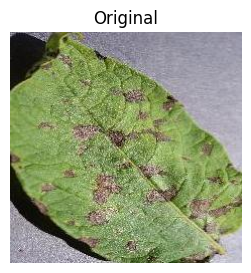

In [ ]:
import matplotlib.pyplot as plt

all_imgs = [orig_img]
titles   = ["Original"]

fig, axs = plt.subplots(1, 1, figsize=(6, 3))  # Adjusted to show only one subplot

ax = axs  # Since there's only one image, we don't need to loop
ax.imshow(orig_img)
ax.set_title("Original")
ax.axis("off")

plt.show()


here's the photo with rotating to create new image

In [ ]:
# Rotating the original image in three different ways
# rotated_imgs = [T.RandomRotation(degrees=d)(orig_img) for d in range(50,151,50)]
# rotated_imgs

center_crops = [T.CenterCrop(size=size)(orig_img) for size in (128,64, 32)]
center_crops

[<PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=32x32>]

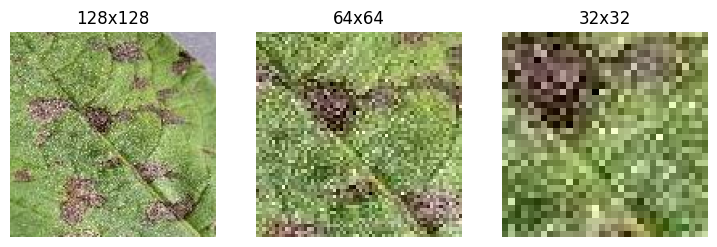

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(9,3))

for ax, img, size in zip(axs, center_crops, (128, 64, 32)):
    ax.imshow(img)
    ax.set_title(f"{size}x{size}")
    ax.axis("off")

plt.show()


In [ ]:
import os, time, random
from pathlib import Path
from PIL import Image
import torchvision.transforms as T

# Use your existing dirs
train_dir = Path("data/idata/Image Dataset/ImageDataset/train")
valid_dir = Path("data/idata/Image Dataset/ImageDataset/valid")
test_dir  = Path("data/idata/Image Dataset/test_data/test")  # flat files; do NOT augment

def _is_image(p: Path, exts={".jpg",".jpeg",".png",".bmp",".JPG",".JPEG",".PNG",".BMP"}):
    return p.is_file() and p.suffix in exts

def _looks_original(name: str):
    """
    Treat files with exactly three underscore-separated tokens before extension
    as originals, e.g. 'potato_early_1000.JPG'.
    This avoids re-augmenting already-augmented files like *_ccrp_1.JPG, *_rrot_2.JPG, etc.
    """
    stem = name.rsplit(".", 1)[0]
    return len(stem.split("_")) == 3

def augment_images_in(folderpath: Path, destination_folder: Path|None=None, seed: int = 42):
    """
    Augment all ORIGINAL images in `folderpath` and save into `destination_folder` (defaults to same folder).
    - Applies: small rotations, several center crops, and gaussian blur variants.
    - Skips .svn and already-augmented files.
    """
    start_time = time.time()
    destination_folder = destination_folder or folderpath
    destination_folder.mkdir(parents=True, exist_ok=True)

    # Reproducible randomness (not strictly needed here but good practice)
    random.seed(seed)

    files = [p for p in folderpath.iterdir() if _is_image(p) and _looks_original(p.name)]
    if not files:
        print(f"[augment] No original images found in: {folderpath}")
        return f"0 files augmented in {folderpath} (no originals found)."

    # Define lightweight, sensible augmentations
    rotation_angles = (-20, 20)                # small tilts
    crop_sizes      = (240, 220, 200, 180)     # zoom-in center crops
    blur_sigmas     = (1.0, 1.5, 2.0)          # mild blur levels
    # Note: kernel_size must be odd int (or odd tuple); use 31 for a moderate blur window
    gaussian_blur   = lambda s: T.GaussianBlur(kernel_size=31, sigma=s)

    saved = 0
    for p in files:
        img = Image.open(p).convert("RGB")
        base = p.stem  # e.g., 'potato_early_1000'

        # 1) rotations
        for i, a in enumerate(rotation_angles, 1):
            # deterministic "rotation": use fixed degree range (a,a) so it’s not random per run
            rot = T.RandomRotation(degrees=(a, a))(img)
            out = destination_folder / f"{base}_rrot_{i}.JPG"
            if not out.exists():
                rot.save(out)
                saved += 1

        # 2) center crops
        for i, sz in enumerate(crop_sizes, 1):
            c = T.CenterCrop(size=sz)(img)
            out = destination_folder / f"{base}_ccrp_{i}.JPG"
            if not out.exists():
                c.save(out)
                saved += 1

        # 3) gaussian blur
        for i, s in enumerate(blur_sigmas, 1):
            b = gaussian_blur(s)(img)
            out = destination_folder / f"{base}_gblr_{i}.JPG"
            if not out.exists():
                b.save(out)
                saved += 1

    msg = f"[augment] Saved {saved} file(s) into {destination_folder} in {time.time()-start_time:.1f}s"
    print(msg)
    return msg


In [ ]:
training_folders = os.listdir(train_dir)
training_folders

['tomato_late',
 'potato_early',
 'potato_late',
 'tomato_healthy',
 'potato_healthy',
 'tomato_early']

In [ ]:
for fol in training_folders:
    augment_images_in(folderpath = train_dir / fol,
                      destination_folder = train_dir / fol)


[augment] Saved 3405 file(s) into data/idata/Image Dataset/ImageDataset/train/tomato_late in 692.0s
[augment] Saved 5022 file(s) into data/idata/Image Dataset/ImageDataset/train/potato_early in 313.0s
[augment] Saved 5022 file(s) into data/idata/Image Dataset/ImageDataset/train/potato_late in 312.2s
[augment] Saved 8631 file(s) into data/idata/Image Dataset/ImageDataset/train/tomato_healthy in 539.5s
[augment] Saved 819 file(s) into data/idata/Image Dataset/ImageDataset/train/potato_healthy in 51.2s
[augment] Saved 5022 file(s) into data/idata/Image Dataset/ImageDataset/train/tomato_early in 311.8s


In [ ]:
total_sum = 0
for folder in os.listdir(train_dir):
    total_sum += len(os.listdir(os.path.join(train_dir, folder)))
    print(f"Len files in {folder}: {len(os.listdir(os.path.join(train_dir, folder)))}\n")
total_sum

Len files in tomato_late: 13398

Len files in potato_early: 7020

Len files in potato_late: 7020

Len files in tomato_healthy: 10634

Len files in potato_healthy: 2827

Len files in tomato_early: 7020



47919

{'potato_early': 7020, 'potato_healthy': 2827, 'potato_late': 7020, 'tomato_early': 7020, 'tomato_healthy': 10634, 'tomato_late': 13398}
Total: 47919


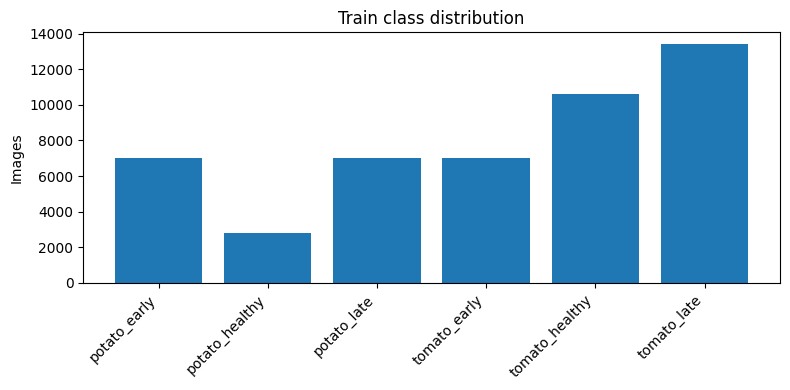

Class weights (use in loss):
potato_early: 0.900
potato_healthy: 2.235
potato_late: 0.900
tomato_early: 0.900
tomato_healthy: 0.594
tomato_late: 0.472


In [ ]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

train_dir = Path("data/idata/Image Dataset/ImageDataset/train")

# Count files per class
cls_names = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
cls_counts = []
for c in cls_names:
    n = len([f for f in (train_dir/c).iterdir() if f.is_file()])
    cls_counts.append(n)
print(dict(zip(cls_names, cls_counts)))
print("Total:", sum(cls_counts))

# Bar chart
plt.figure(figsize=(8,4))
plt.bar(cls_names, cls_counts)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Images")
plt.title("Train class distribution")
plt.tight_layout()
plt.show()

# Compute class weights (inverse frequency)
counts = np.array(cls_counts, dtype=np.float64)
weights = (counts.sum() / (len(counts) * counts))  # classic 1/freq normalized
class_weights = weights / weights.sum() * len(weights)  # rescale ~1.0 average
print("Class weights (use in loss):")
for name, w in zip(cls_names, class_weights):
    print(f"{name}: {w:.3f}")

# If you’ll use PyTorch:
# import torch
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
# criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)


What/why:

Bar plot shows imbalance clearly.

class_weights counteract imbalance when you define your loss: CrossEntropyLoss(weight=...).

If training becomes too slow with ~48k images, you can:
• use a smaller num_workers and larger batch_size,
• train fewer epochs,
• or train on a SubsetRandomSampler for a quicker first pass.

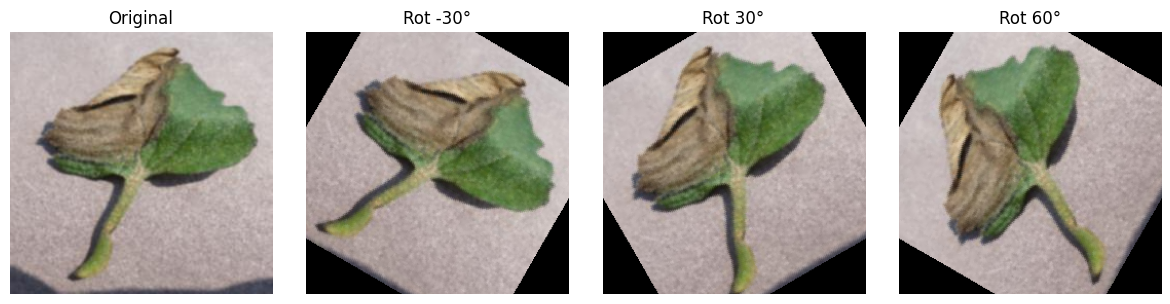

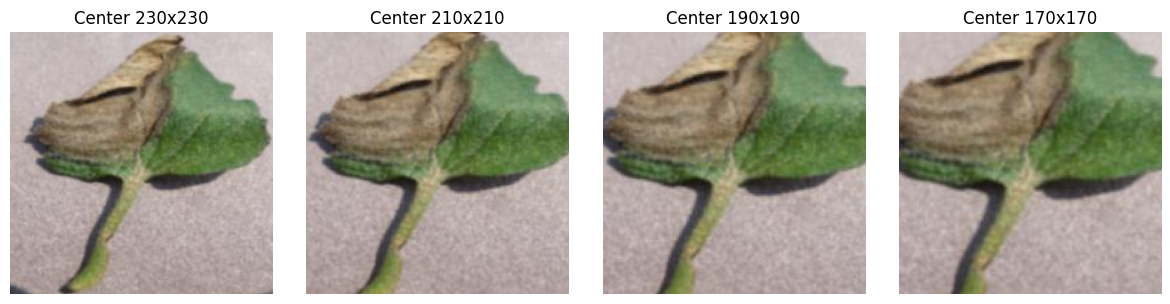

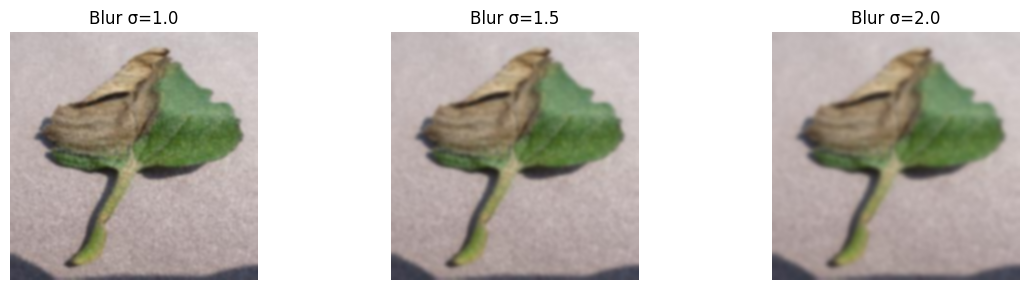

In [ ]:
# --- A) simple, non-interactive plotting helper (define first) ---
import matplotlib.pyplot as plt

def show_row(images, titles=None, figsize=(12,3)):
    plt.figure(figsize=figsize)
    n = len(images)
    for i, img in enumerate(images, 1):
        plt.subplot(1, n, i)
        plt.imshow(img)
        plt.axis("off")
        if titles and i-1 < len(titles):
            plt.title(titles[i-1])
    plt.tight_layout()
    plt.show()

# --- B) demo augmentations on one training image (tomato_late) ---
from pathlib import Path
from PIL import Image
import torchvision.transforms as T
import os, random

train_dir = Path("data/idata/Image Dataset/ImageDataset/train")
sample_folder = train_dir / "tomato_late"
sample_files = [f for f in os.listdir(sample_folder) if f.lower().endswith((".jpg",".jpeg",".png",".bmp"))]
assert len(sample_files) > 0, "No images found in tomato_late."
random.seed(0)
sample_path = sample_folder / random.choice(sample_files)

image = Image.open(sample_path).convert("RGB")

# choose explicit angles so lists have consistent lengths
angles1 = [ -30,  30,  60 ]
angles2 = [ 100, 120, 140 ]
rotated_imgs  = [T.RandomRotation((a, a))(image) for a in angles1]
rotated_imgs2 = [T.RandomRotation((a, a))(image) for a in angles2]

# crops + blurs
center_crops = [T.CenterCrop(size=s)(image) for s in (230, 210, 190, 170)]
blurred_imgs = [T.GaussianBlur(kernel_size=31, sigma=s)(image) for s in (1.0, 1.5, 2.0)]

# visualize
show_row([image] + rotated_imgs,  ["Original"] + [f"Rot {a}°" for a in angles1])
show_row(center_crops,            [f"Center {s}x{s}" for s in (230,210,190,170)])
show_row(blurred_imgs,            [f"Blur σ={s}" for s in (1.0,1.5,2.0)])


---------------------------------------

In [ ]:
from pathlib import Path

def list_zero_byte_files(root: Path):
    bad = []
    if root.is_dir():
        for p in root.rglob("*"):
            if p.is_file() and p.stat().st_size == 0:
                bad.append(p)
    return bad

train_dir = Path("data/idata/Image Dataset/ImageDataset/train")
valid_dir = Path("data/idata/Image Dataset/ImageDataset/valid")
test_dir  = Path("data/idata/Image Dataset/test_data/test")

for name, folder in [("train", train_dir), ("valid", valid_dir), ("test", test_dir)]:
    bad = list_zero_byte_files(folder)
    print(f"{name}: {len(bad)} zero-byte files")
    if bad[:5]:
        print("  examples:", [str(p) for p in bad[:5]])


train: 0 zero-byte files
valid: 0 zero-byte files
test: 1 zero-byte files
  examples: ['data/idata/Image Dataset/test_data/test/.svn/wc.db-journal']


In [ ]:
from pathlib import Path
import os

def get_data_splits_to(filepath: str|Path):
    """Print per-class counts and split suggestion (60/20/20 here just as a reference)."""
    filepath = Path(filepath)
    total_sum = 0
    folders = []
    print("="*70)
    for folder in sorted([d.name for d in filepath.iterdir() if d.is_dir()]):
        folders.append(folder)
        n = len([f for f in (filepath/folder).iterdir() if f.is_file()])
        total_sum += n
        print(f"Total files in {folder}: {n}")
        print(f"Train (60%): ~{round(0.6*n)}")
        print(f"Valid (20%): ~{round(0.2*n)}")
        print(f"Test  (20%): ~{round(0.2*n)}\n" + "="*70)
    print("Classes:", folders)
    print(f"TOTAL in this split root: {total_sum}")

get_data_splits_to("data/idata/Image Dataset/ImageDataset/train")


Total files in potato_early: 7020
Train (60%): ~4212
Valid (20%): ~1404
Test  (20%): ~1404
Total files in potato_healthy: 2827
Train (60%): ~1696
Valid (20%): ~565
Test  (20%): ~565
Total files in potato_late: 7020
Train (60%): ~4212
Valid (20%): ~1404
Test  (20%): ~1404
Total files in tomato_early: 7020
Train (60%): ~4212
Valid (20%): ~1404
Test  (20%): ~1404
Total files in tomato_healthy: 10634
Train (60%): ~6380
Valid (20%): ~2127
Test  (20%): ~2127
Total files in tomato_late: 13398
Train (60%): ~8039
Valid (20%): ~2680
Test  (20%): ~2680
Classes: ['potato_early', 'potato_healthy', 'potato_late', 'tomato_early', 'tomato_healthy', 'tomato_late']
TOTAL in this split root: 47919


###Datasets & Dataloaders

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# --- 1. Define transforms ---
# training gets augmentation, valid/test only resize + normalize
train_transforms = transforms.Compose([
    transforms.Resize((256,256)),             # bring to common size
    transforms.RandomResizedCrop(224),        # random crop + scale jitter
    transforms.RandomHorizontalFlip(p=0.5),   # flip
    transforms.RandomRotation(20),            # +/- 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])  # ImageNet stats
])

valid_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),             # fixed size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# --- 2. Point to dataset dirs ---
train_dir = "data/idata/Image Dataset/ImageDataset/train"
valid_dir = "data/idata/Image Dataset/ImageDataset/valid"
test_dir  = "data/idata/Image Dataset/test_data/test"

# --- 3. Create Datasets ---
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(root=valid_dir, transform=valid_test_transforms)

# test set is flat (no subfolders), so we use a trick:
# we'll wrap it in a generic Dataset later — for now we just know it's raw images.

# --- 4. Dataloaders ---
batch_size = 32
num_workers = 2 if torch.cuda.is_available() else 0

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# peek: class names
print("Classes:", train_data.classes)
print("Num train batches:", len(train_loader))
print("Num valid batches:", len(valid_loader))


Classes: ['potato_early', 'potato_healthy', 'potato_late', 'tomato_early', 'tomato_healthy', 'tomato_late']
Num train batches: 1498
Num valid batches: 42


Why we do this

Transforms:

Train: add randomness (cropping, jitter, rotation, flips) → boosts robustness.

Valid/Test: only resize + normalize → must reflect real-world unseen data.

Normalization: standard mean/std from ImageNet pretrained models.

ImageFolder: expects structure root/class_name/images..., which you already have.

Dataloader: batches data, shuffles train set, parallel loads with workers.

###Model + Loss + Optimizer (+ class weights)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from collections import Counter
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- 1) Infer number of classes from the train dataset ---
num_classes = len(train_data.classes)
print("Classes:", train_data.classes)

# --- 2) Compute class weights from the train dataset (handles imbalance) ---
# ImageFolder stores samples as (path, class_idx)
targets = [label for _, label in train_data.samples]
counts = np.bincount(targets, minlength=num_classes).astype(np.float64)
print("Per-class counts:", dict(zip(train_data.classes, counts.tolist())))

# inverse frequency weights (normalized to ~1 avg)
weights = (counts.sum() / (len(counts) * counts))
class_weights = torch.tensor(weights / weights.mean(), dtype=torch.float32, device=device)
print("Class weights:", {c: float(w) for c, w in zip(train_data.classes, class_weights)})

# --- 3) Build EfficientNet-B0 backbone (pretrained on ImageNet) ---
backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# replace classifier head to match our classes
in_features = backbone.classifier[1].in_features
backbone.classifier[1] = nn.Linear(in_features, num_classes)

model = backbone.to(device)

# --- 4) Loss (with class weights), optimizer, scheduler ---
criterion = nn.CrossEntropyLoss(weight=class_weights)

# AdamW is a solid default for transfer learning
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# optional: cosine schedule (smooth LR decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# --- 5) (Optional) freeze early layers for a short warmup, then unfreeze later ---
# For first few epochs you can freeze features to train only the head:
# for p in model.features.parameters():
#     p.requires_grad = False
# print("Frozen features for warmup (uncomment block above if you want warmup)")


Device: cpu
Classes: ['potato_early', 'potato_healthy', 'potato_late', 'tomato_early', 'tomato_healthy', 'tomato_late']
Per-class counts: {'potato_early': 7020.0, 'potato_healthy': 2827.0, 'potato_late': 7020.0, 'tomato_early': 7020.0, 'tomato_healthy': 10634.0, 'tomato_late': 13398.0}
Class weights: {'potato_early': 0.8999140858650208, 'potato_healthy': 2.2346646785736084, 'potato_late': 0.8999140858650208, 'tomato_early': 0.8999140858650208, 'tomato_healthy': 0.5940753221511841, 'tomato_late': 0.4715178906917572}
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 111MB/s] 


###Training & Validation Loop

In [ ]:
import numpy as np
import torch
from torch.utils.data import Subset, DataLoader
from torchvision import transforms, datasets
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import f1_score
from torch.cuda.amp import autocast, GradScaler

# -------------------------
# 1) SPEED SETTINGS
# -------------------------
CAP_PER_CLASS = 600        # try 600 (or 300 if still slow)
IMG_SIZE      = 160        # 160x160 is much cheaper than 224
BATCH_SIZE    = 64         # larger batch = fewer steps
NUM_EPOCHS    = 3          # quick run to validate the pipeline
SMOKE_MAX_BATCHES = 200    # limit batches/epoch (set None to use all)
NUM_WORKERS   = 2 if torch.cuda.is_available() else 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
print("Device:", device)

# -------------------------
# 2) TRANSFORMS (lighter)
# -------------------------
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.15, 0.15, 0.15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

eval_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

# -------------------------
# 3) DATASETS
# -------------------------
train_root = "data/idata/Image Dataset/ImageDataset/train"
valid_root = "data/idata/Image Dataset/ImageDataset/valid"

train_data_full = datasets.ImageFolder(root=train_root, transform=train_transforms)
valid_data      = datasets.ImageFolder(root=valid_root, transform=eval_transforms)
class_names     = train_data_full.classes
num_classes     = len(class_names)
print("Classes:", class_names)

# Cap train samples per class for speed
targets = np.array([y for _, y in train_data_full.samples])
subset_indices = []
for c in range(num_classes):
    idx = np.where(targets == c)[0]
    np.random.shuffle(idx)
    subset_indices.extend(idx[:min(CAP_PER_CLASS, len(idx))].tolist())
np.random.shuffle(subset_indices)
train_data = Subset(train_data_full, subset_indices)
print("Using capped train samples:", len(train_data))

# -------------------------
# 4) DATALOADERS
# -------------------------
pin = torch.cuda.is_available()
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=pin, persistent_workers=bool(NUM_WORKERS))
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=pin, persistent_workers=bool(NUM_WORKERS))

# -------------------------
# 5) MODEL (smaller + fast): MobileNetV3-Small
# -------------------------
backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
in_feats = backbone.classifier[3].in_features
backbone.classifier[3] = nn.Linear(in_feats, num_classes)
model = backbone.to(device)

# class weights (from capped train set)
subset_targets = np.array([train_data_full.samples[i][1] for i in subset_indices])
counts = np.bincount(subset_targets, minlength=num_classes).astype(np.float64)
weights = (counts.sum() / (len(counts) * counts))
class_weights = torch.tensor(weights / weights.mean(), dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# -------------------------
# 6) TRAIN LOOP (AMP + optional batch cap)
# -------------------------
def train_fast(model, criterion, optimizer, scheduler, train_loader, valid_loader,
               epochs=NUM_EPOCHS, device=device, max_batches=SMOKE_MAX_BATCHES):
    best_f1 = 0.0
    scaler = GradScaler(enabled=(device.type == "cuda"))
    history = {"train_loss": [], "valid_loss": [], "train_acc": [], "valid_acc": [], "train_f1": [], "valid_f1": []}

    for epoch in range(1, epochs+1):
        print(f"\nEpoch {epoch}/{epochs}")
        print("-"*28)

        # TRAIN
        model.train()
        tr_loss, tr_correct, tr_total = 0.0, 0, 0
        y_true, y_pred = [], []
        for b, (x, y) in enumerate(train_loader, 1):
            if max_batches and b > max_batches: break
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=(device.type == "cuda")):
                out = model(x)
                loss = criterion(out, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            tr_loss += loss.item() * x.size(0)
            preds = out.detach().argmax(1)
            tr_correct += (preds == y).sum().item()
            tr_total += y.size(0)
            y_true.extend(y.cpu().numpy()); y_pred.extend(preds.cpu().numpy())

        from sklearn.metrics import f1_score
        tr_f1 = f1_score(y_true, y_pred, average="macro") if tr_total else 0.0
        tr_loss = tr_loss / max(1, tr_total)
        tr_acc  = tr_correct / max(1, tr_total)

        # VALID
        model.eval()
        va_loss, va_correct, va_total = 0.0, 0, 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for b, (x, y) in enumerate(valid_loader, 1):
                if max_batches and b > max_batches//2: break  # validate faster
                x, y = x.to(device), y.to(device)
                with autocast(enabled=(device.type == "cuda")):
                    out = model(x); loss = criterion(out, y)
                va_loss += loss.item() * x.size(0)
                preds = out.argmax(1)
                va_correct += (preds == y).sum().item()
                va_total += y.size(0)
                y_true.extend(y.cpu().numpy()); y_pred.extend(preds.cpu().numpy())

        va_f1 = f1_score(y_true, y_pred, average="macro") if va_total else 0.0
        va_loss = va_loss / max(1, va_total)
        va_acc  = va_correct / max(1, va_total)

        if scheduler is not None:
            scheduler.step()

        print(f"Train  | loss {tr_loss:.4f}  acc {tr_acc:.3f}  F1 {tr_f1:.3f}")
        print(f"Valid  | loss {va_loss:.4f}  acc {va_acc:.3f}  F1 {va_f1:.3f}")

        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc); history["train_f1"].append(tr_f1)
        history["valid_loss"].append(va_loss); history["valid_acc"].append(va_acc); history["valid_f1"].append(va_f1)

        if va_f1 > best_f1:
            best_f1 = va_f1
            torch.save(model.state_dict(), "best_model.pth")
            print(f"✅ saved best model (val F1: {best_f1:.3f})")

    print("\nDone. Best val F1:", best_f1)
    return history

history = train_fast(model, criterion, optimizer, scheduler, train_loader, valid_loader)


Device: cpu
Classes: ['potato_early', 'potato_healthy', 'potato_late', 'tomato_early', 'tomato_healthy', 'tomato_late']
Using capped train samples: 3600
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 69.8MB/s]
/tmp/ipython-input-618182352.py:99: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))



Epoch 1/3
----------------------------


/tmp/ipython-input-618182352.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
/tmp/ipython-input-618182352.py:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Train  | loss 0.5758  acc 0.816  F1 0.814
Valid  | loss 0.7544  acc 0.730  F1 0.725
✅ saved best model (val F1: 0.725)

Epoch 2/3
----------------------------


/tmp/ipython-input-618182352.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
/tmp/ipython-input-618182352.py:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Train  | loss 0.1079  acc 0.962  F1 0.962
Valid  | loss 0.2013  acc 0.922  F1 0.921
✅ saved best model (val F1: 0.921)

Epoch 3/3
----------------------------


/tmp/ipython-input-618182352.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
/tmp/ipython-input-618182352.py:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Train  | loss 0.0570  acc 0.982  F1 0.982
Valid  | loss 0.1197  acc 0.960  F1 0.960
✅ saved best model (val F1: 0.960)

Done. Best val F1: 0.9600784911249344


###Plot training curves

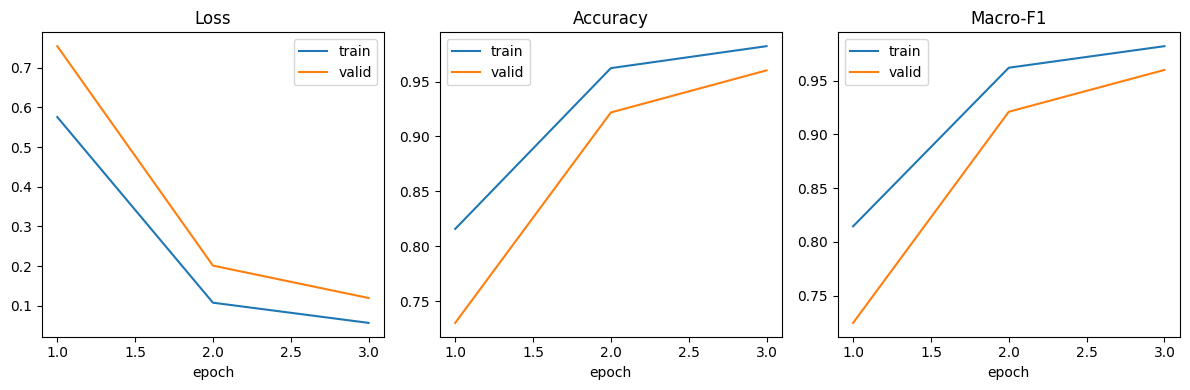

In [ ]:
import matplotlib.pyplot as plt

def plot_curves(history):
    epochs = range(1, len(history["train_loss"])+1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(epochs, history["train_loss"], label="train")
    plt.plot(epochs, history["valid_loss"], label="valid")
    plt.title("Loss"); plt.xlabel("epoch"); plt.legend()

    plt.subplot(1,3,2)
    plt.plot(epochs, history["train_acc"], label="train")
    plt.plot(epochs, history["valid_acc"], label="valid")
    plt.title("Accuracy"); plt.xlabel("epoch"); plt.legend()

    plt.subplot(1,3,3)
    plt.plot(epochs, history["train_f1"], label="train")
    plt.plot(epochs, history["valid_f1"], label="valid")
    plt.title("Macro-F1"); plt.xlabel("epoch"); plt.legend()

    plt.tight_layout(); plt.show()

plot_curves(history)


###Evaluate the test folder (flat filenames)

Test images: 1331
                precision    recall  f1-score   support

  potato_early      0.982     0.995     0.989       221
potato_healthy      0.750     1.000     0.857        30
   potato_late      0.910     0.959     0.934       221
  tomato_early      0.936     0.928     0.932       221
tomato_healthy      0.952     1.000     0.976       220
   tomato_late      0.987     0.907     0.945       418

      accuracy                          0.951      1331
     macro avg      0.920     0.965     0.939      1331
  weighted avg      0.954     0.951     0.951      1331



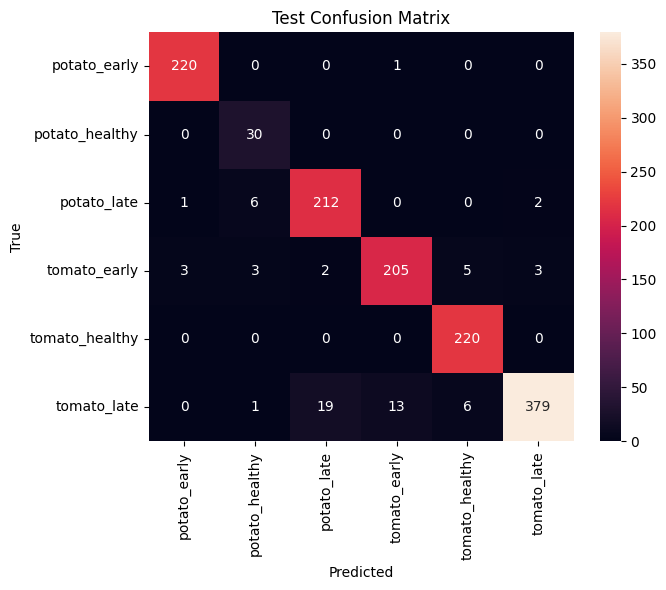

In [ ]:
from pathlib import Path
from PIL import Image
from torchvision import transforms
import re
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_dir = Path("data/idata/Image Dataset/test_data/test")
class_to_idx = train_data_full.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}

# same preprocessing as valid
test_tf = eval_transforms

def filename_to_class(name: str):
    # e.g. "tomato_late_369.JPG" -> "tomato_late"
    stem = Path(name).stem
    parts = stem.split("_")
    if len(parts) >= 2:
        return f"{parts[0]}_{parts[1]}"
    raise ValueError(f"Unrecognized filename pattern: {name}")

# build test lists (images + labels from filename)
test_imgs, test_labels = [], []
for p in sorted(test_dir.iterdir()):
    if p.is_file() and p.suffix.lower() in [".jpg",".jpeg",".png",".bmp"]:
        cls_name = filename_to_class(p.name)
        if cls_name in class_to_idx:
            test_imgs.append(p)
            test_labels.append(class_to_idx[cls_name])

print("Test images:", len(test_imgs))

# run evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for p, lab in zip(test_imgs, test_labels):
        img = Image.open(p).convert("RGB")
        x = test_tf(img).unsqueeze(0).to(device)
        out = model(x)
        pred = out.argmax(1).item()
        y_true.append(lab); y_pred.append(pred)

print(classification_report(y_true, y_pred, target_names=train_data_full.classes, digits=3))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=train_data_full.classes,
            yticklabels=train_data_full.classes)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Test Confusion Matrix")
plt.tight_layout(); plt.show()


###Final inference (with image preview)
Use predict_and_show as your fast default (one pass).

Use predict_tta when a photo is tricky (field noise, shadows) — it averages several augmented views and is usually more accurate, but a bit slower.

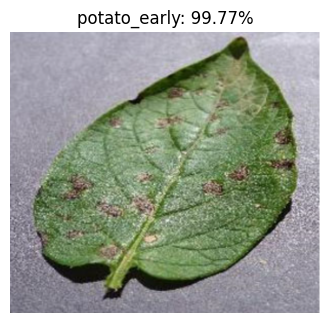

Top-3:
potato_early         99.77%
potato_late          0.12%
tomato_healthy       0.07%


In [ ]:
import torchvision.models as models
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# reload best model (MobileNetV3-Small with our head)
num_classes = len(train_data_full.classes)
backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
in_feats = backbone.classifier[3].in_features
backbone.classifier[3] = nn.Linear(in_feats, num_classes)
model = backbone.to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

infer_tf = eval_transforms
idx_to_class = {v:k for k,v in train_data_full.class_to_idx.items()}

def predict_and_show(path):
    img = Image.open(path).convert("RGB")
    x = infer_tf(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
    topk = probs.argsort()[-3:][::-1]
    title = f"{idx_to_class[topk[0]]}: {probs[topk[0]]:.2%}"
    plt.figure(figsize=(4,4)); plt.imshow(img); plt.axis("off"); plt.title(title)
    plt.show()
    print("Top-3:")
    for k in topk:
        print(f"{idx_to_class[k]:<20} {probs[k]:.2%}")

# Example:
predict_and_show("potatoEARLY.png")


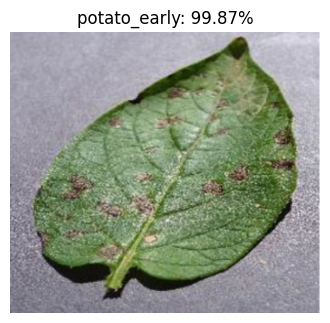

Top-3:
potato_early         99.87%
potato_late          0.10%
tomato_healthy       0.02%


In [ ]:
import torch
from torchvision import transforms
import torchvision.transforms.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

idx_to_class = {v:k for k,v in train_data_full.class_to_idx.items()}

# Use same IMG_SIZE you trained with (160 in fast mode). If you trained at 224, use 224.
IMG_SIZE = 160
base_norm = transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])

def to_tensor_norm(pil):
    return base_norm(transforms.ToTensor()(pil))

def predict_tta(img_path, model, device, k=3):
    img = Image.open(img_path).convert("RGB")

    # build TTA views
    views = []

    # original + flips
    base = transforms.Resize((IMG_SIZE, IMG_SIZE))(img)
    views.append(base)
    views.append(F.hflip(base))
    views.append(F.vflip(base))

    # light rotations
    views.append(base.rotate(15))
    views.append(base.rotate(-15))

    # 5-crop around the center (zoom in slightly)
    big = transforms.Resize((IMG_SIZE+40, IMG_SIZE+40))(img)
    crops = transforms.FiveCrop(IMG_SIZE)(big)  # returns 5 PIL images
    views.extend(crops)

    # run model on all views and average softmax
    probs_sum = None
    model.eval()
    with torch.no_grad():
        for v in views:
            x = to_tensor_norm(v).unsqueeze(0).to(device)
            p = torch.softmax(model(x), dim=1)  # (1, C)
            probs_sum = p if probs_sum is None else probs_sum + p

    probs = (probs_sum / len(views)).squeeze(0).cpu().numpy()
    topk = probs.argsort()[-k:][::-1]

    # show
    plt.figure(figsize=(4,4)); plt.imshow(img); plt.axis("off")
    plt.title(f"{idx_to_class[topk[0]]}: {probs[topk[0]]:.2%}")
    plt.show()

    print("Top-3:")
    for c in topk:
        print(f"{idx_to_class[c]:<20} {probs[c]:.2%}")

# Example
predict_tta("potatoEARLY.png", model, device)
